In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
from tqdm import tqdm_notebook

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


# Load model

In [2]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)


# Decoding
decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(8, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss='mse')

In [4]:
# load weights into new model
autoencoder_256_cnn.load_weights("./floyd/autoencoder_256_cnn_reversed.h5")
print("Loaded model from disk")

Loaded model from disk


# Load test data

In [7]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/defective_pics/'

data_proxy = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_proxy.append(gray_resize/255.)

data_proxy = np.reshape(data_proxy, (len(data_proxy), 256, 256, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

# Test the model

In [10]:
data.shape

(126, 256, 256, 1)

In [ ]:
# Proxy testing
encoded_imgs_256_cnn = encoder_256_cnn.predict(data[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data[:, :, :, ])

NameError: name 'data' is not defined

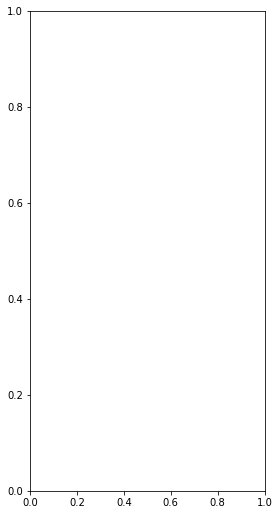

In [9]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 30))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#     # display encoded images
#     ax = plt.subplot(3, 20, i + 1 + 20)
#     plt.imshow(encoded_imgs_256_cnn[i].reshape(32,32))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs_256_cnn[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [33]:
difference = []
for i in range(data.shape[0]):
    diff = (data[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference.append(diff)
    print(diff)
    

4.1662358146568295
4.883558181521948
10.200270148285199
12.144624253211077
5.973450605524704
4.095878083637217
2.509627616760554
6.730300068331417
10.534764356823871
15.904231729218736
7.638369478750974
7.195127694110852
12.114267973927781
3.646650948183378
3.199874021753203
3.207812223408837
6.447250081953825
2.5439964015968144
4.709534494264517
3.2157543276262004
7.2175459387362935
10.272683728660922
7.9253607068094425
7.898593239573529
2.9862251069571357
2.335146819561487
2.9591986032028217
15.717667336226441
4.368054649356054
9.108352055656724
5.833957850118168
20.381691655959003
3.183946105913492
12.4831066763727
11.969083444215357
3.1283544706966495
7.7672547147085425
3.151012840186013
5.799908020911971
5.980037067667581
4.15698952486855
4.155956548056565
9.959887948643882
5.881586898176465
6.615255135227926
2.642733895336278
7.23440432958887
7.9954067685466725
4.951634300494334
14.690439274068922
5.53486167427036
13.453380992403254
10.169387121422915
4.352521794615313
7.34494456

In [34]:
np.mean(difference)

7.519283147662622

# Mixing good and bad images

In [5]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/machine_y/'

data_y = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_y.append(gray_resize/255.)
#         i+=1
        
# #         if i==15000:
# #             break


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

In [ ]:
data_y = np.array(data_y)

In [32]:
data_256_cnn = data_y/255.

train_256_cnn = data_256_cnn[:20000, :, :]
test_256_cnn = data_256_cnn[20000:, :, :]

train_256_cnn = np.reshape(train_256_cnn, (len(train_256_cnn), 256, 256, 1))
test_256_cnn = np.reshape(test_256_cnn, (len(test_256_cnn), 256, 256, 1))

In [33]:
np.random.shuffle(test_256_cnn)

In [34]:
data = np.append(data_proxy, test_256_cnn[:200], axis=0)

In [35]:
np.random.shuffle(data)

In [36]:
data.shape

(326, 256, 256, 1)

In [37]:
# Proxy testing
# encoded_imgs_256_cnn = encoder_256_cnn.predict(data)
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data)

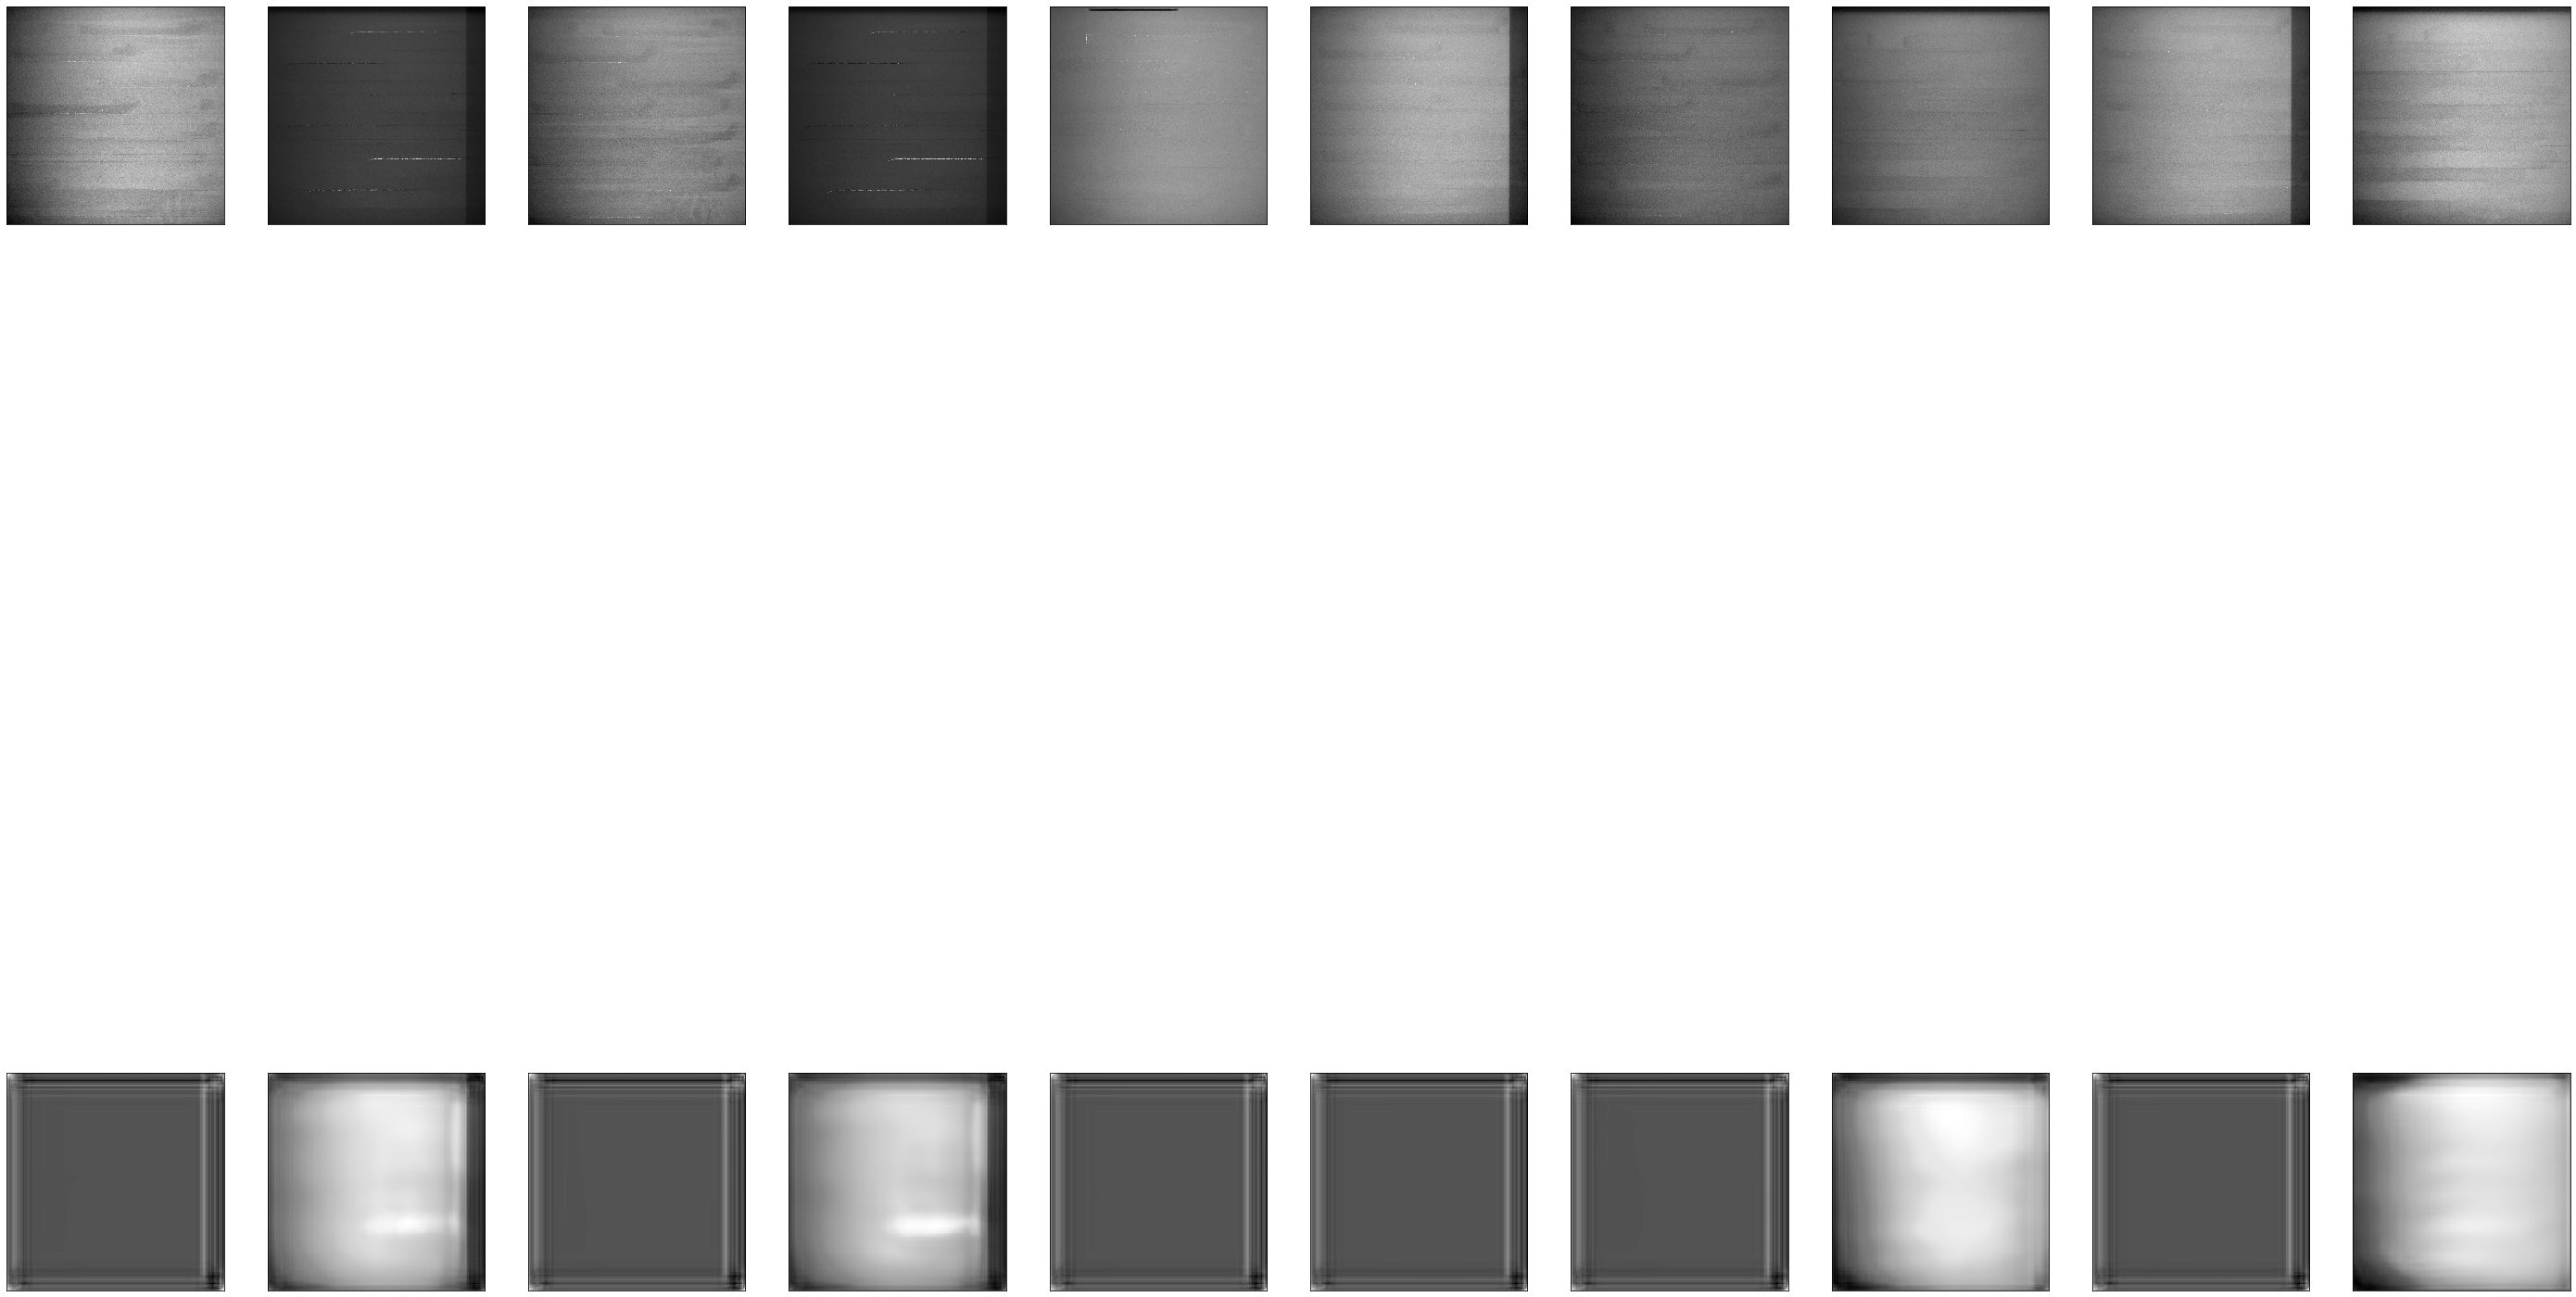

In [38]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 30))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#     # display encoded images
#     ax = plt.subplot(3, 20, i + 1 + 20)
#     plt.imshow(encoded_imgs_256_cnn[i].reshape(32,32))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs_256_cnn[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [53]:
difference = []
for i in range(data.shape[0]):
    diff = (-data[i, :, :, ]*255. + decoded_imgs_256_cnn[i]*255.).mean()
    difference.append(diff)
    print(diff)
    

14.880700356997927
-3.193397609560634
14.83844816761774
-3.108348926441977
14.826158512465547
14.838165311408673
14.890276918055417
-3.589976982824737
14.823011555007628
-6.615255135227926
-2.509627616760554
14.87520698668377
-11.969083444215357
-10.169387121422915
14.84261791739536
14.874473547351554
14.881464646042437
-13.515703583369032
-12.4831066763727
14.773337269230822
-15.717667336226441
14.768796739546602
-2.467701134359231
14.856845925898105
-7.137378870713292
14.836295956545483
14.76878083354025
14.886020078543131
-10.272683728660922
-7.344944562442834
14.874587312028698
-13.453380992403254
-4.243606349948095
-4.192729198926827
-5.799908020911971
14.86211487881716
-3.2034002896107268
14.86648251150152
14.637579750878508
14.895500252481114
14.822044775688546
-3.223416290435125
14.683775355334664
14.876108539723033
14.874859762623236
14.880145368636322
14.84632728124463
-3.2157543276262004
14.838475061198338
14.842306467272811
-4.352521794615313
14.866730171256894
14.882071128

In [47]:
np.mean(difference)

832.3085199990412

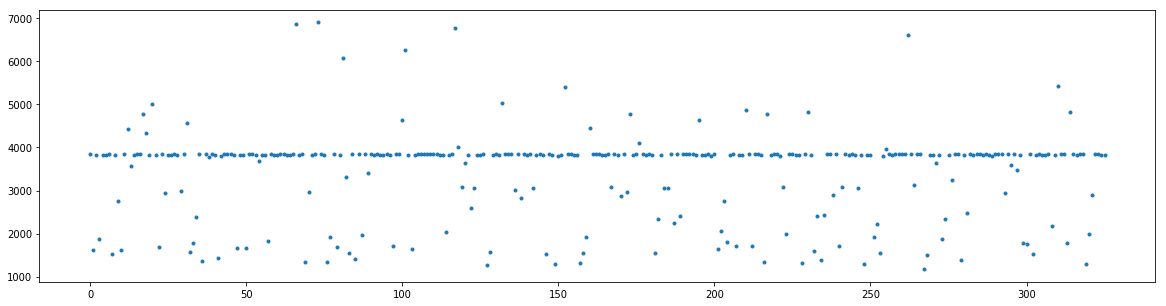

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(difference, 'o', ms=3)

In [58]:
import h5py
h5f = h5py.File('./validataion.h5', 'w')
h5f.create_dataset('/validation', data=data)
h5f.close()

In [62]:
h5f = h5py.File('./application/validatation.h5', 'r')
data_test = h5f['/validation'][:]
h5f.close()

In [81]:
source = './application/validation.h5'
h5f = h5py.File(source, 'r')
data = h5f['/validation'][:]
h5f.close()

decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data[:, :, :, :])

difference = []
for i in range(data.shape[0]):
    diff = (data[i, :, :, :] - decoded_imgs_256_cnn[i]).mean()
    difference.append(diff)

In [112]:
data_proxy = np.reshape(data, (326, 256, 256))
images = []
i = 0
for image in data_proxy:
    scipy.misc.imsave('./images/' + str(i) + '.jpg', image*255.)
    images.append('./images/' + str(i) + '.jpg')
    i+=1

/Users/alexanderkornyukhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


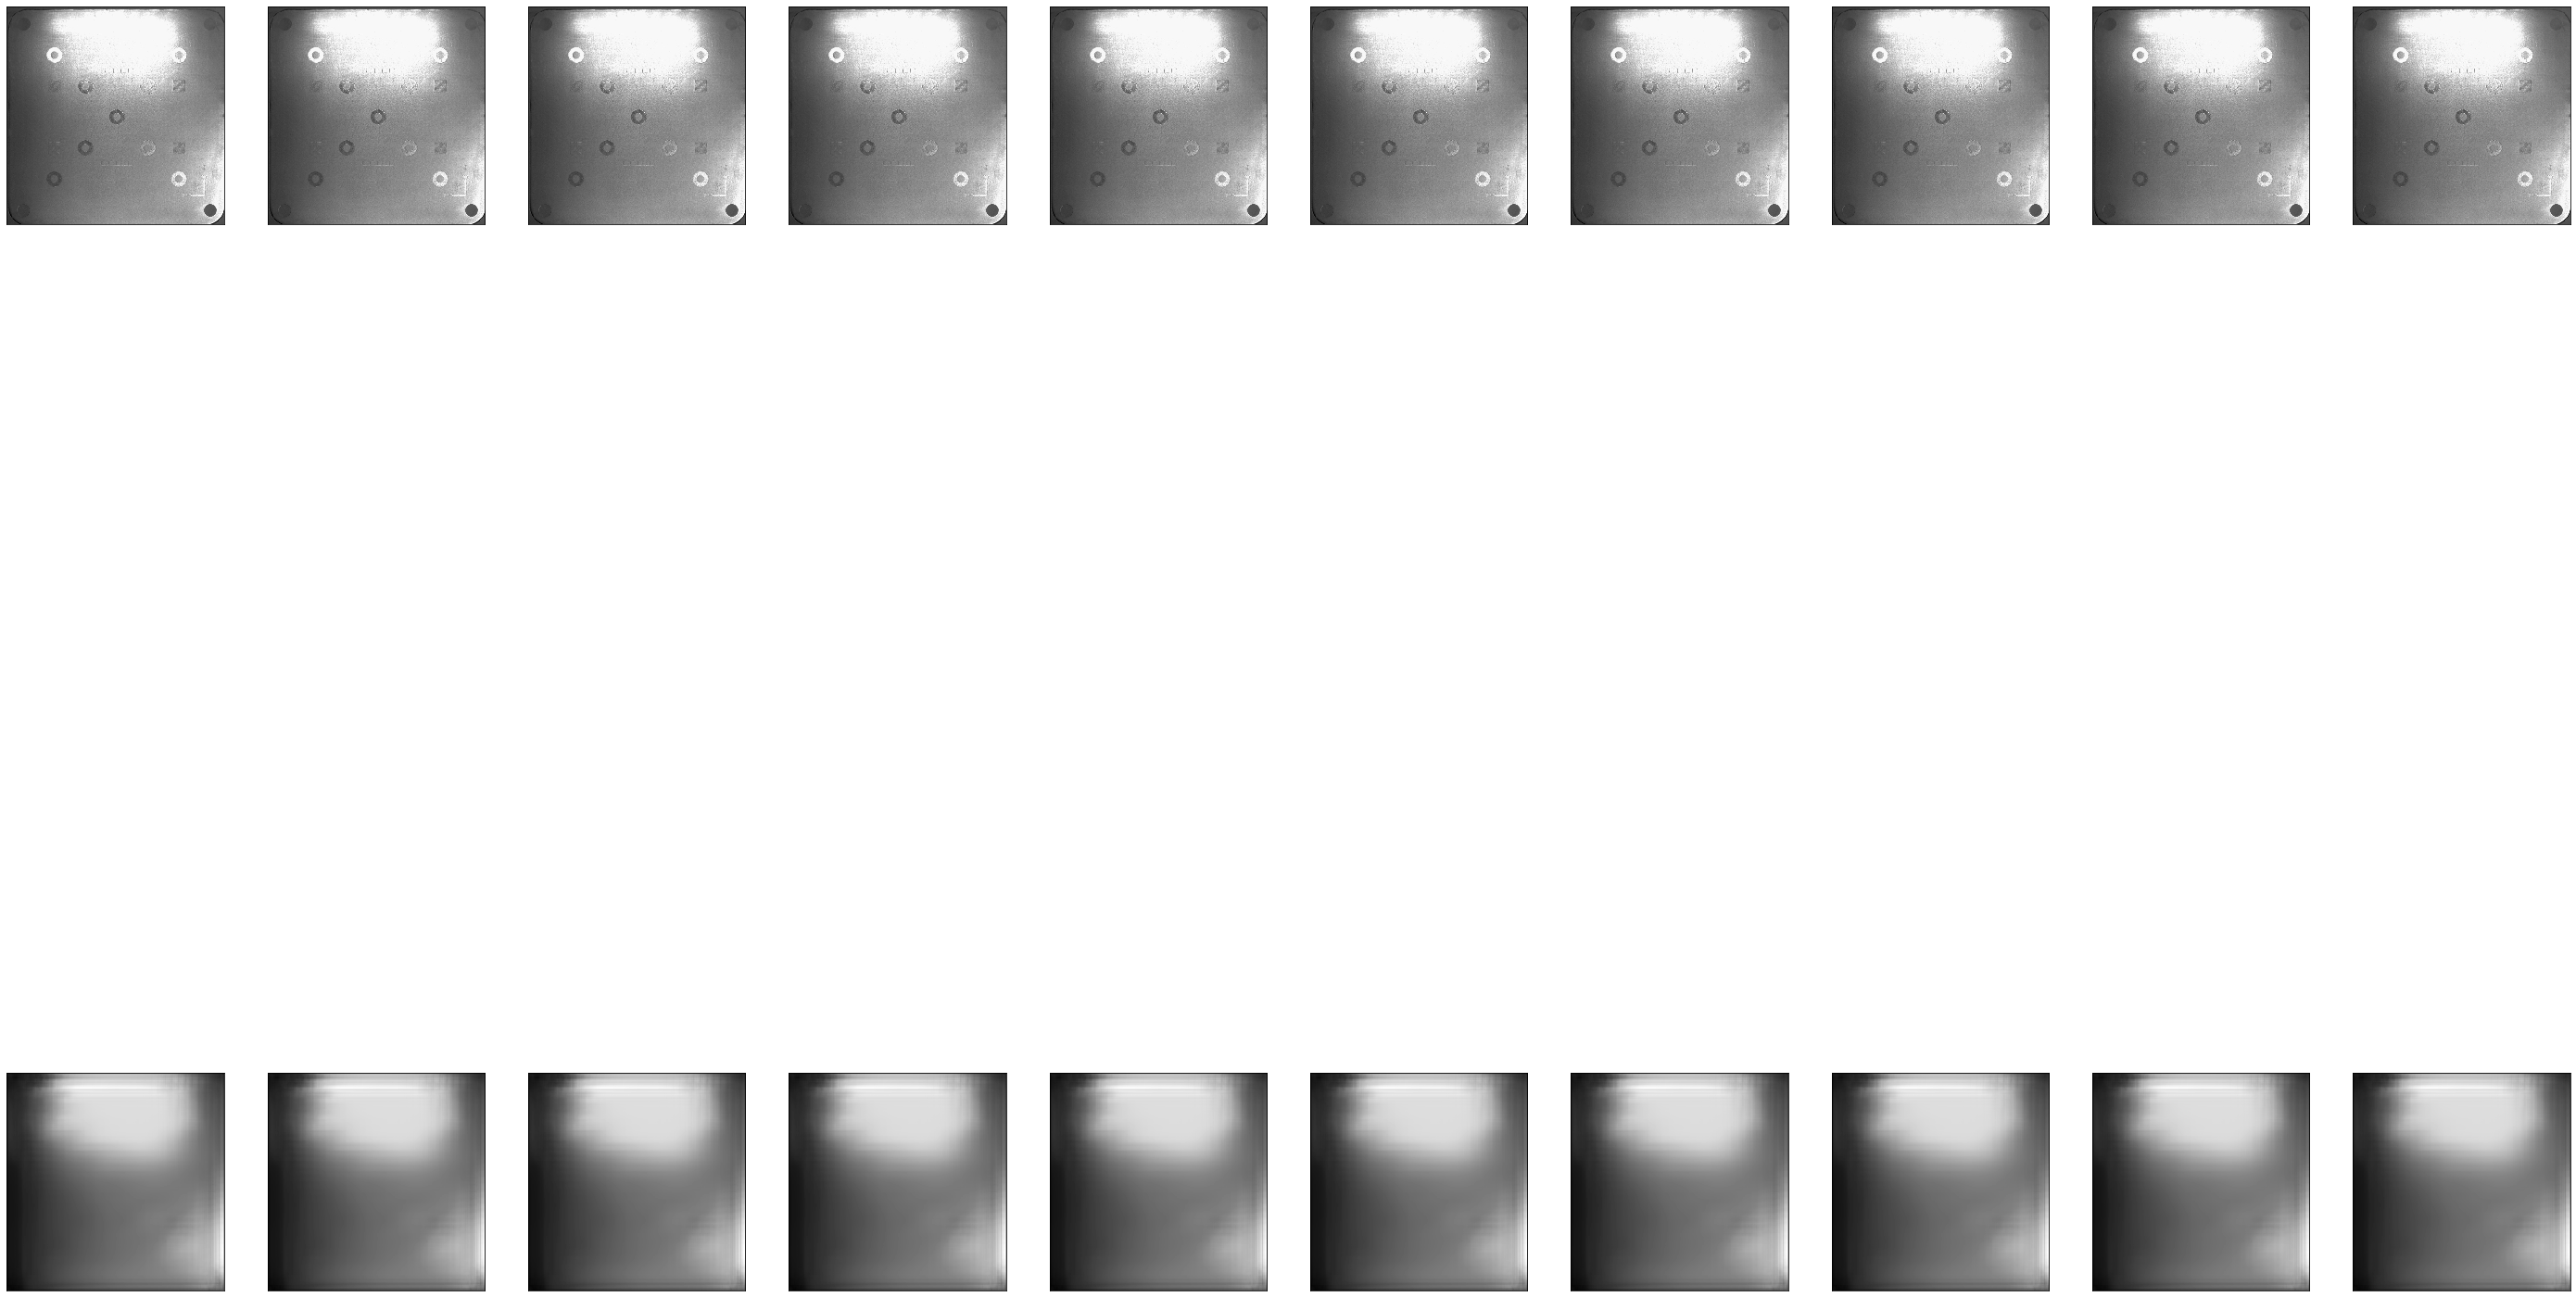

In [122]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 30))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(gray_resize.reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#     # display encoded images
#     ax = plt.subplot(3, 20, i + 1 + 20)
#     plt.imshow(encoded_imgs_256_cnn[i].reshape(32,32))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_imgs_256_cnn.reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

# Testing filters viz

In [11]:
import h5py

source = './data/validation.h5'
h5f = h5py.File(source, 'r')
data = h5f['/validation'][:]
h5f.close()


In [19]:
import numpy as np
import os
from tqdm import tqdm_notebook
import cv2

directory = './data/new_data_y/test_data/defective_pics/'

data = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data.append(gray_resize/255.)

data = np.reshape(data_proxy, (len(data_proxy), 256, 256, 1))


# df_y = pd.DataFrame(data_y.T)
# store = pd.HDFStore('./machine_data.h5')
# store['/machine_y_128'] = df_y
# store.close()

In [20]:
# Proxy testing
encoded_imgs_256_cnn = encoder_256_cnn.predict(data[:, :, :, ])
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data[:, :, :, ])

In [22]:
encoded_imgs_256_cnn.shape

(126, 32, 32, 32)

In [ ]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 300))
for i in range(10):
    # display original images
    ax = plt.subplot(34, 10, i + 1)
    plt.imshow(data[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_256_cnn.shape[3]):
        ax = plt.subplot(34, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_256_cnn[i,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(34, 10, 330 + i + 1)
    plt.imshow(decoded_imgs_256_cnn[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [61]:
import scipy.misc

for i in range(encoded_imgs_256_cnn.shape[0]):
    for j in range(encoded_imgs_256_cnn[i, :, :, :].shape[2]):
        scipy.misc.imsave('./static/img/image_' + str(i) + '_filter_' + str(j) + '.jpg', encoded_imgs_256_cnn[i, :, :, j]*255.)
#         images.append('./static/img/image_' + str(i) + '_filter_' + str(j) + '.jpg')
        
        

/Users/alexanderkornyukhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


In [64]:
for i in range(encoded_imgs_256_cnn[0, :, :, :].shape[2]):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [58]:
encoded_imgs_256_cnn[i, :, :, 0]*255.

array([[11.445793 ,  8.716219 ,  2.0454805, ...,  0.       ,  0.       ,
         0.       ],
       [13.429804 , 13.564106 ,  5.4317365, ...,  0.       ,  0.       ,
         0.       ],
       [ 6.2532163,  5.708648 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [22.771214 , 22.885187 , 14.852086 , ...,  0.       ,  0.       ,
         0.       ],
       [26.39123  , 26.493977 , 19.585308 , ...,  0.       ,  0.       ,
         0.       ],
       [22.990168 , 23.035648 , 16.057947 , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [62]:
decoded_imgs_256_cnn.shape

(326, 256, 256, 1)

In [66]:
for i in range(encoded_imgs_256_cnn.shape[0]):
    for j in range(encoded_imgs_256_cnn.shape[i, :, :, :][2]):
        scipy.misc.imsave('./static/img/image_' + str(i) + '_filter_' + str(j) + '.jpg', encoded_imgs_256_cnn[i, :, :, j]*255.)
        filters['filter'+str(j)].append('./static/img/image_' + str(i) + '_filter_' + str(j) + '.jpg')
        
        

TypeError: tuple indices must be integers or slices, not tuple

In [70]:
cv2.resize(encoded_imgs_256_cnn[i, :, :, 0]*255., (256, 256)).shape

(256, 256)

In [71]:
(encoded_imgs_256_cnn[i, :, :, 0]*255.).shape

(32, 32)